# Incoherent-Excitation in Monomers
## Calculations for the paper: *sanity checks, convergence & analysis*

In [48]:
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

import UD_liouv as RC
import driving_liouv as EM
import ME_checking as check
import exact_IB as exact
import scipy as sp
import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard

reload(RC)
reload(EM)
reload(check)
reload(exact)
plt.style.use('ggplot')

Things to do in these notes:
- Convergence of RC theory with respect to N for increasing alpha:
    - a) Overdamped
    - b) Low and high-frequency under-damped
- Are all my overdamped parameters working correctly? Is $w_0 = \epsilon$ sufficient?
- I need to check that the exact solution gives me what I want: At which coupling strengths, mode frequencies, temperatures is the RC method valid?
- How about with underdamped modes?

- Look at vibronic/electronic eigenstate populations across windows of validity.

In [49]:
# Things that will always be true
G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.
J_EM = EM.J_minimal
# Things that are true by default but are subject to overriding
## ~~ Parameters ~~

eps = 0.1*8065.5 # TLS splitting
#eps = 2.*1519.3 # ps
T_EM = 6000. # Optical bath temperature
#H_S = eps*E*E.dag()
#alpha_EM = 0.3 # System-bath strength (optical)
Gamma_EM = 0.1*5.309 #bare decay of electronic transition from inv. ps to in inv. cm
#Gamma_EM = 6.582E-7*1519.3
T_ph = 300. # Phonon bath temperature
overdamped = True
phonon_only = True
#fig1wc = 53.*0.188

''' RC stuff '''
N = 15
#w0 = 200.*0.188
Gamma = 60. # Width of distribution
alpha_ph = 3*eps # Ind.-Boson frame coupling
beta = beta_f(T_ph)#1/(0.695*T_ph)
wc = 1*53. # Ind.-Boson frame phonon cutoff freq
shift = 0.5*np.pi*alpha_ph
w0 = eps+50 #-100 # underdamped SD parameter omega_0
optical_cutoff = 20000.
if overdamped:
        Gamma = (w0**2)/wc
n_RC = EM.Occupation(w0, T_ph)
#initial_sys = G*G.dag()
#initial_sys = E*E.dag()
#initial_sys = 0.5*(G+E)*(E.dag()+G.dag())
initial_sys = 0.5*(E+G)*(E+G).dag()

rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
#print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

# Expectation values and time increments needed to calculate the dynamics
expects_wc = [G*G.dag(), E*G.dag()]
expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
           tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
           tensor(qeye(2), destroy(N).dag()+destroy(N))]
nTimeSteps = 250
timelist = np.linspace(0, 0.07, nTimeSteps)

## Convergence of spectral densities and dynamics

Firstly, with what values of $\omega_0$ does the overdamped limit of underdamped SD converge?



In [158]:

alpha_ph = 1*eps
nsteps = 1000
w = np.linspace(0., 3*eps, nsteps)
w0_i = 1.2*eps
w0_f = w0_i+2.5*eps
# total error is naturally a function of nsteps
total_error = np.sqrt(sum((J_underdamped(
                    w, 1*eps, w0_i**2/wc, w0_i)-J_underdamped(
                    w, 1*eps, w0_f**2/wc, w0_f))**2))
print "Average SD error per step: {}".format(total_error/nsteps)

opts = qt.Options(nsteps=5000)

Gamma_i = w0_i**2/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_i, w0_i, alpha_ph, N)
DATA_sc_i =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True).expect[1])

Gamma_f = w0_f**2/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_f, w0_f, alpha_ph, N)
DATA_sc_f =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True, options=opts).expect[1])

total_error_dyn = np.sqrt(abs(sum(DATA_sc_i-DATA_sc_f)**2))
print "Average (approx.) error in each timestep: {}".format(total_error_dyn/float(nTimeSteps))

Average SD error per step: 0.0131119193741
w_RC= 967.86  TLS splitting = 806.55 RC-res. bath coupling= 2.90640949473  N= 15 TLS-RC coupling= 1107.3422158 Gamma_RC=  17674.5845208
10.0%. Run time:   0.81s. Est. time left: 00:00:00:07
20.0%. Run time:   1.69s. Est. time left: 00:00:00:06
30.0%. Run time:   2.51s. Est. time left: 00:00:00:05
40.0%. Run time:   3.32s. Est. time left: 00:00:00:04
50.0%. Run time:   4.17s. Est. time left: 00:00:00:04
60.0%. Run time:   4.97s. Est. time left: 00:00:00:03
70.0%. Run time:   5.81s. Est. time left: 00:00:00:02
80.0%. Run time:   6.65s. Est. time left: 00:00:00:01
90.0%. Run time:   7.51s. Est. time left: 00:00:00:00
Total run time:   8.25s
w_RC= 2984.235  TLS splitting = 806.55 RC-res. bath coupling= 8.96142927543  N= 15 TLS-RC coupling= 1944.4290286 Gamma_RC=  168031.293117
10.0%. Run time:   6.78s. Est. time left: 00:00:01:00
20.0%. Run time:  14.09s. Est. time left: 00:00:00:56
30.0%. Run time:  21.36s. Est. time left: 00:00:00:49
40.0%. Run 

KeyboardInterrupt: 

THings seem to converge fairly well where $\omega_0>\epsilon$. The greater $\omega_0$ is, the longer the calculations take but (generally) fewer states are needed.

Secondly, convergence of RC theory dynamics. For some fairly strong coupling, when do the calculations stop changing appreciably with increasing N?

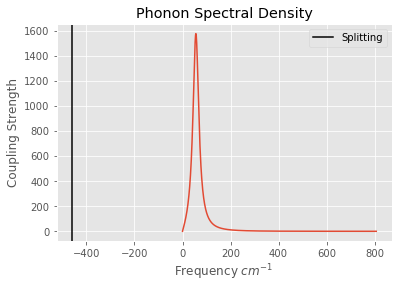

w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 3 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  2262.95585404  ** Took: 0.0481200218201s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 4 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  21.4726229875  ** Took: 0.0569508075714s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 5 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  12.6462674654  ** Took: 0.0781440734863s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 6 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  8.43157874111  ** Took: 0.117270946503s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 7 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  5.97829191139  ** Took: 0.163492918015s**
w_RC= 57.6107142857  TLS splitting = 806.5

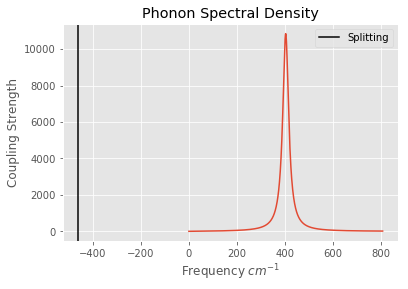

w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 3 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  2178.32180528  ** Took: 0.0790479183197s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 4 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  22.8914321995  ** Took: 0.0774779319763s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 5 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  15.7224566903  ** Took: 0.11413192749s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 6 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  10.3793022194  ** Took: 0.139351129532s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 7 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  6.89942610082  ** Took: 0.170650959015s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.01183968332

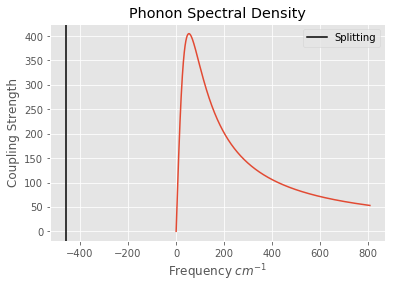

w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 3 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  2249.72456626  ** Took: 0.0864169597626s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 4 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  3.52865902509  ** Took: 0.120508909225s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 5 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  1.69743184955  ** Took: 0.190084934235s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 6 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  0.757291000406  ** Took: 0.262411117554s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 7 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  0.289945761051  ** Took: 0.401604175568s**
w_RC= 806.55  TLS splitting = 806.55 RC-re

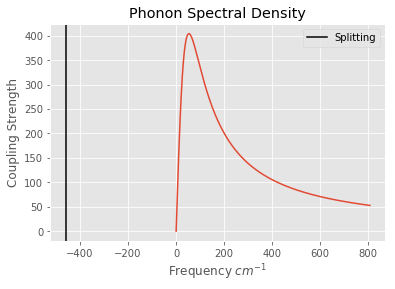

w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 3 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  2249.84762911  ** Took: 0.104517936707s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 4 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  4.14495418802  ** Took: 0.173388004303s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 5 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  2.16080057981  ** Took: 0.29558300972s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 6 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  1.04259495135  ** Took: 0.438542127609s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 7 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  0.382326522188  ** Took: 0.701153039932s**
w_RC= 1209.825  TLS splitting = 806

In [128]:

def integers(ni = 2, step=1):
    i = ni
    while True:
        i+=step
        yield i


def convergence_checker(alpha_prop, w0_prop, Gamma_, overdamped=False, threshold=10E-8):
    N_gen = integers()
    last_rc_sol = np.array([1])
    current_rc_sol = np.array([3])
    alpha_ph = eps*alpha_prop
    shift = 0.5*np.pi*alpha_ph
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.axvline(eps-shift, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    while sum(abs(last_rc_sol - current_rc_sol)**2) >threshold:
        
        N = N_gen.next()
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects_wc = [G*G.dag(), E*G.dag()]
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma_, 
                                                    w0, alpha_ph, N)
        DATA_sc =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects).expect[1])
        tf = time.time()
        last_rc_sol = np.array(current_rc_sol)
        current_rc_sol =  DATA_sc
        print '\t ** Error: ', sum(abs(
                last_rc_sol - current_rc_sol)**2), " ** Took: {}s**".format(tf-ti)

convergence_checker(1., 1./14., 30., threshold=10E-6)
convergence_checker(1., 1./2, 30., threshold=10E-6)

convergence_checker(1., 1., 0, overdamped=True, threshold=10E-6)
convergence_checker(1., 1.5, 0, overdamped=True, threshold=10E-6)

Underdamped:
- $\alpha=\epsilon$, $\omega_0=\epsilon/14, \Gamma=30cm^{-1}$ : converges at N=27 in 2.73s
- $\alpha=\epsilon$, $\omega_0=\epsilon/2, \Gamma=30cm^{-1}$ : converges at N=23 in 2.40s

Overdamped:
- $\alpha=\epsilon$, $\omega_0=1.5\epsilon, \Gamma=12274cm^{-1}$ : converges at N=16 in 6.6s
- $\alpha=\epsilon$, $\omega_0=2\epsilon, \Gamma=27617cm^{-1}$ : converges at N=15 in 9.17s

where $\Gamma$ is the width of the Lorentzian spectral density.

## Comparison to exact solution

How well does the RC theory agree with exact?
- w_0 dependence
- alpha dependence

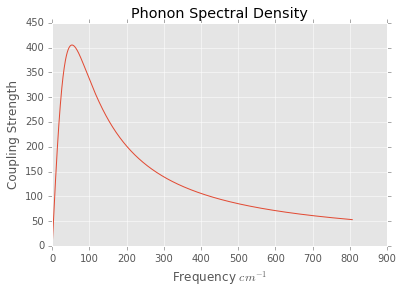

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 8.28446507454 seconds.
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 17 TLS-RC coupling= 175.086177559 Gamma_RC=  12274.0170283


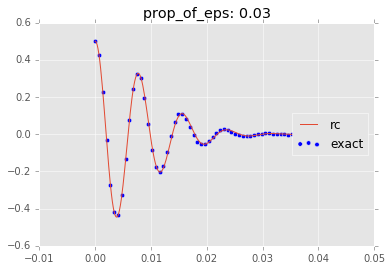

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 43.5602328777 seconds.
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 17 TLS-RC coupling= 725.428892213 Gamma_RC=  12274.0170283


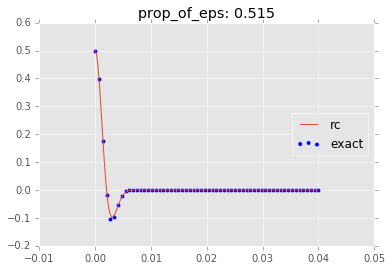

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 54.1279900074 seconds.
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 17 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283


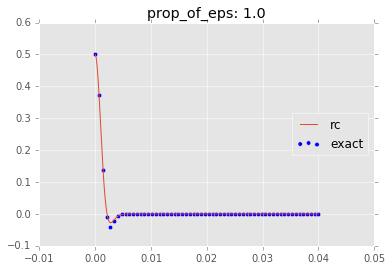

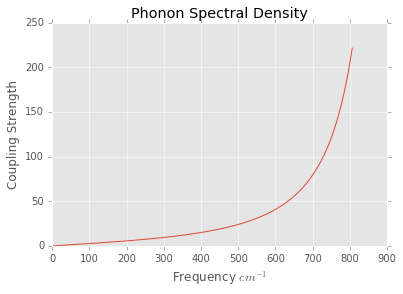

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 7.10632801056 seconds.
w_RC= 967.86  TLS splitting = 806.55 RC-res. bath coupling= 0.00493320138528  N= 23 TLS-RC coupling= 191.797297913 Gamma_RC=  30


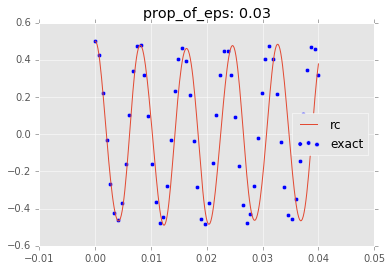

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 17.546257019 seconds.
w_RC= 967.86  TLS splitting = 806.55 RC-res. bath coupling= 0.00493320138528  N= 23 TLS-RC coupling= 794.667536262 Gamma_RC=  30


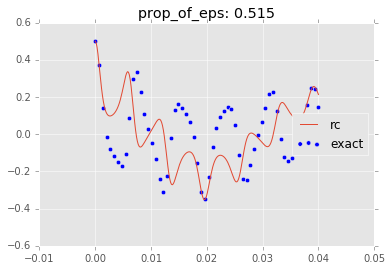

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 23.904227972 seconds.
w_RC= 967.86  TLS splitting = 806.55 RC-res. bath coupling= 0.00493320138528  N= 23 TLS-RC coupling= 1107.3422158 Gamma_RC=  30


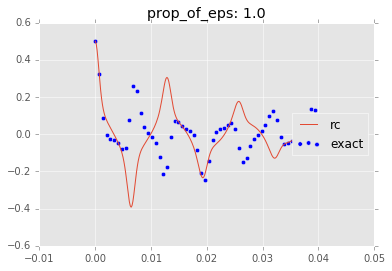

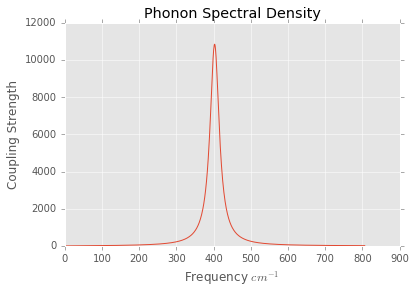

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 5.66478681564 seconds.
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 23 TLS-RC coupling= 123.804623444 Gamma_RC=  30


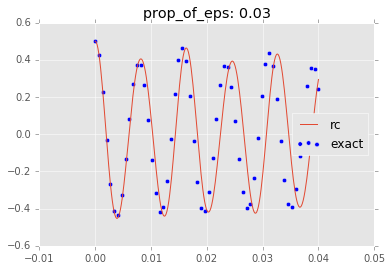

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 7.98740887642 seconds.
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 23 TLS-RC coupling= 512.955688953 Gamma_RC=  30


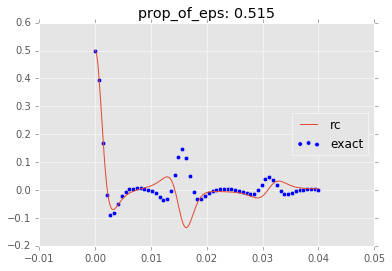

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 8.2501502037 seconds.
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 23 TLS-RC coupling= 714.786326724 Gamma_RC=  30


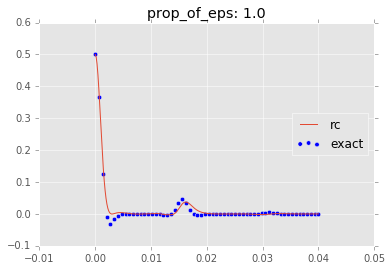

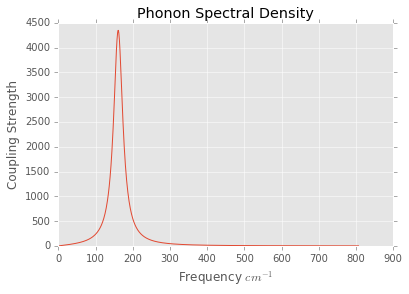

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 2.8883869648 seconds.
w_RC= 161.31  TLS splitting = 806.55 RC-res. bath coupling= 0.0295992083117  N= 27 TLS-RC coupling= 78.3009189886 Gamma_RC=  30


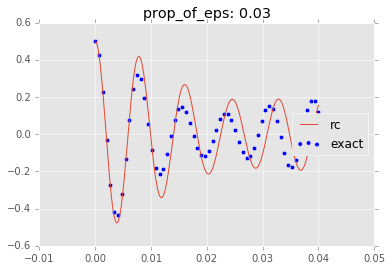

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 6.49095082283 seconds.
w_RC= 161.31  TLS splitting = 806.55 RC-res. bath coupling= 0.0295992083117  N= 27 TLS-RC coupling= 324.421663166 Gamma_RC=  30


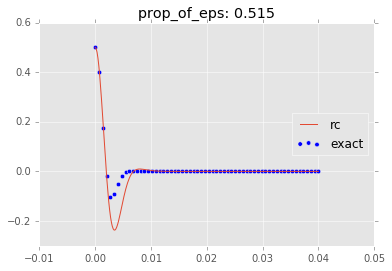

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 6.95128798485 seconds.
w_RC= 161.31  TLS splitting = 806.55 RC-res. bath coupling= 0.0295992083117  N= 27 TLS-RC coupling= 452.070566559 Gamma_RC=  30


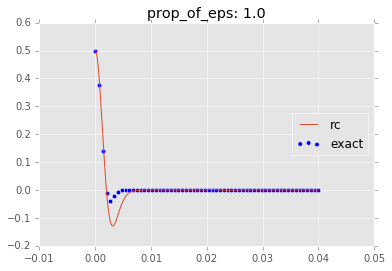

In [27]:

def exact_comparison_alpha(w0_prop, Gamma_, N=3, overdamped=False):
    timelist_exact = np.linspace(0, 0.04, 60)
    timelist = np.linspace(0, 0.04, 250)
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    
    exact_sol = []
    rc_sol = []
    prop_of_eps = np.linspace(0.03,1,3)
    for prop in prop_of_eps:
        # how well
        alpha = prop*eps
        shift = 0. #0.5*np.pi*alpha*0.25
        ti = time.time()
        rho_01 = np.array(exact.exact_dynamics(eps, alpha, wc, 
                                               w0, Gamma_, beta, initial_sys, 
                                               timelist_exact, overdamped=overdamped))
        print "Exact dynamics calculated"
        print "Exact solution took {} seconds.".format(time.time()-ti)
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma_, 
                                                                       w0, alpha, N)
        #print H_RC.eigenenergies()
        #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
        DATA_sc = mesolve(H_RC, rho_0, timelist, [L_RC], expects).expect[1].real
        #exact_sol.append(rho_01.real)
        #rc_sol.append(DATA_sc.real)
        plt.figure()
        plt.title("prop_of_eps: {}".format(prop))
        plt.scatter(timelist_exact, rho_01, label="exact")
        plt.plot(timelist, DATA_sc, label="rc")
        # Everything is oscillating at the shifted frequency
        #plt.plot(timelist, 0.5*np.exp((-50.-1j*(eps-shift))*timelist))  
        plt.legend(loc='right')
        plt.show()
        
exact_comparison_alpha(1., 0, N=17, overdamped=True)
exact_comparison_alpha(1.2, 30, N=23, overdamped=False)
exact_comparison_alpha(1./2., 30, N=23, overdamped=False)
exact_comparison_alpha(1./5., 30, N=27, overdamped=False)
#

#exact_comparison_alpha(1., 0., N=16, overdamped=True)
#exact_comparison_alpha(2., 0., N=15, overdamped=True)

So we can see that for broad overdamped environments the RC method works extremely well, however for more structured environments it doesn't match the exact solution.

Now we will look at decay rates at short times and $T_{EM}=0$ from the $|e,0\rangle \to |g,k\rangle$ states.

In [172]:
from qutip import vector_to_operator, operator_to_vector

def eigstate_calc_and_mag_sort(H):
    # Helper function to calculate the eigenstates and sort
    # in order of eigvalue magnitude
    evals, evecs = H.eigenstates()
    evals, evecs = zip(*sorted(list(zip(evals, evecs)), key=lambda x: abs(x[0])))
    return np.array(evals), np.array(evecs)


def decay_rate_plotter(eps, T_ph, w0, overdamped=True, nvib=3):
    alpha_ph = np.linspace(0.001,1.5,30)*eps
    displacements = alpha_ph/w0
    if overdamped:
        Gamma_ = w0**2/wc
    else:
        Gamma_ = 60.
    decay_wrt_alpha = [[],[],[]]
    for alpha_ in alpha_ph:
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(sigma, eps, T_ph, Gamma_, w0, alpha_, 14)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = eigstate_calc_and_mag_sort(H)
        ground_list = []
        excited_list = []
        for i in range(6): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        initial_bra = states[excited_list[0]].dag()
        init_rho = initial_bra.dag()*initial_bra
        
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, 0, J=J_EM), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, 0, J=J_EM),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, 0, J=J_EM)]
        for i_, L_EM in enumerate(L):
            decay_rates = [] # not really decay rates but population at short times
            for ground_vibronic_ket in states[ground_list][0:nvib]:
                decay_rates.append(vector_to_operator(
                                    L_EM*operator_to_vector(init_rho)).matrix_element(
                                        ground_vibronic_ket.dag(),ground_vibronic_ket).real)
            assert len(decay_rates)==nvib
            decay_wrt_alpha[i_].append(decay_rates)
    return displacements, decay_wrt_alpha
"""
    for level in range(nvib):
        plt.figure()
        print len(displacements),len(np.array(decay_wrt_alpha[0]).T[level])
        plt.plot(displacements,np.array(decay_wrt_alpha[0]).T[level], label='non-RWA')
        plt.plot(displacements,np.array(decay_wrt_alpha[1]).T[level], label='non-sec', linestyle='dashed')
        plt.plot(displacements,np.array(decay_wrt_alpha[2]).T[level], label='naive')
        plt.legend()
        plt.xlabel('Oscillator Displacement')
        plt.ylabel('')
    plt.show()
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])
"""
#L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, 0, J=J_EM)
#L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, 0, J=J_EM)
#L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, 0, J=J_EM)
displacements, decay_wrt_alpha = decay_rate_plotter(eps, T_ph, eps)
#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 14 TLS-RC coupling= 31.9662163188 Gamma_RC=  12274.0170283
Calculating non-RWA Liouvilliian took 0.793391942978 seconds.
It took  1.06666707993  seconds to build the Non-secular RWA Liouvillian
It took  0.00651621818542  seconds to build the electronic-Lindblad Liouvillian
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 14 TLS-RC coupling= 232.035221034 Gamma_RC=  12274.0170283
Calculating non-RWA Liouvilliian took 0.797297000885 seconds.
It took  1.14846682549  seconds to build the Non-secular RWA Liouvillian
It took  0.00560903549194  seconds to build the electronic-Lindblad Liouvillian
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 14 TLS-RC coupling= 326.586663254 Gamma_RC=  12274.0170283
Calculating non-RWA Liouvilliian took 0.796159982681 seconds.
It took  1.13784790039  seconds to build the Non-secular RWA Liouvillian
It took  0.0065319538116

AssertionError: 

In [171]:
np.array(decay_wrt_alpha[0])

array([list([0.5292340920033054, 0.0, 0.0]),
       list([0.4482798499332829, 0.0, 0.0]),
       list([0.3767334288690557, 0.0, 0.0]),
       list([0.31361982639956154, 0.0, 0.0]),
       list([0.25805889612867805, 0.0, 0.0]),
       list([0.20925648260592808, 0.0, 0.0]),
       list([0.16649636207613738, 0.0, 0.0]),
       list([0.12913291724897918, 0.0, 0.0]),
       list([0.096584480629500577, 0.0, 0.0]),
       list([0.068327286692825798, 0.0, 0.0]),
       list([0.043889978418630238, 1.4392299589582437e-12, 0.0]),
       list([0.022848618491371986, 0.0, 0.0]),
       list([0.00482215989006427, 0.0, 0.0]),
       list([-1.1567441842445045e-12, 0.0, 0.0]), list([0.0, 0.0, 0.0]),
       list([0.0, 1.2394822633568508e-12, 1.2445582796958033e-12]),
       list([-1.293227758241963e-12, 1.7813860606313159e-12, 1.7880829153826928e-12]),
       list([0.0, 2.4792444157486181e-12, 2.4887761083408341e-12]),
       list([0.0, 0.0, 0.0]), list([0.079761829245925425, 0.0, 0.0]),
       list([0.0

In [15]:
def steadystate_coupling_dependence(prop_couplings, T_ph, eps, Gamma, w0, T_EM, 
                                    Gamma_EM, overdamped=True):
    plt.figure()
    N = 30
    G = ket([0])
    E = ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1

    data_nrwa  = [[],[],[],[],[],[]]
    data_ns  = [[],[],[],[],[],[]]
    data_n  = [[],[],[],[],[],[]]
    labels = ['g-0', 'e-0', 'g-1', 'e-1', 'g-2', 'e-2'] 
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for prop in prop_couplings:
        alpha_ph = prop*eps
        print count
        count+=1
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma, 
                                                                       w0, alpha_ph, N)
        lowest_6 = H_RC.eigenstates()[1][0:6]
        # electromagnetic bath liouvillians
        L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J)
        L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
        #L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
        L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J)

        for j, state in enumerate(lowest_6):
            data_nrwa[j].append(steadystate(H_RC, [L_RC+L_nrwa]).matrix_element(
                                                                state.dag(), state))
            data_ns[j].append(steadystate(H_RC, [L_RC+L_ns]).matrix_element(
                                                                state.dag(), state))
            data_n[j].append(steadystate(H_RC, [L_RC+L_n]).matrix_element(
                                                                state.dag(), state))

    for i, lab in enumerate(labels):
        plt.figure()
        plt.title(lab)
        plt.plot(prop_couplings, data_nrwa[i], label='nrwa')
        plt.plot(prop_couplings, data_ns[i], label='ns')
        plt.plot(prop_couplings, data_n[i], label='n')
        plt.legend()
        plt.grid()
        plt.ylabel("Population")
        plt.xlabel(r"Phonon Coupling Strength: units of $\epsilon$")
    plt.show()

1
RC oscillator frequency= 816.55  splitting = 806.55 residual bath coupling= 0.0116946868967  N= 30 TLS-RC coupling= 0.0 Gamma_RC=  60.0
Calculating non-RWA Liouvilliian took 2.2919549942 seconds.
It took  1.96784210205  seconds to build the Non-secular RWA Liouvillian
It took  0.00317001342773  seconds to build the electronic-Lindblad Liouvillian
2
RC oscillator frequency= 816.55  splitting = 806.55 residual bath coupling= 0.0116946868967  N= 30 TLS-RC coupling= 59.7266255972 Gamma_RC=  60.0
Calculating non-RWA Liouvilliian took 3.28637599945 seconds.
It took  2.63478183746  seconds to build the Non-secular RWA Liouvillian
It took  0.00775098800659  seconds to build the electronic-Lindblad Liouvillian
3
RC oscillator frequency= 816.55  splitting = 806.55 residual bath coupling= 0.0116946868967  N= 30 TLS-RC coupling= 84.4662039544 Gamma_RC=  60.0
Calculating non-RWA Liouvilliian took 3.50996398926 seconds.
It took  2.79014992714  seconds to build the Non-secular RWA Liouvillian
It to

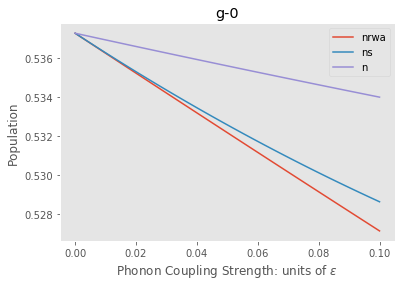

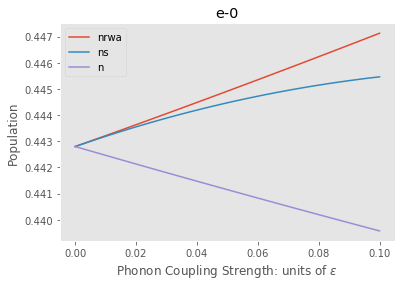

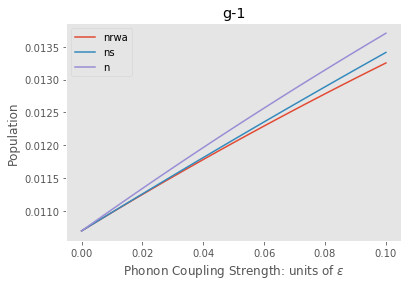

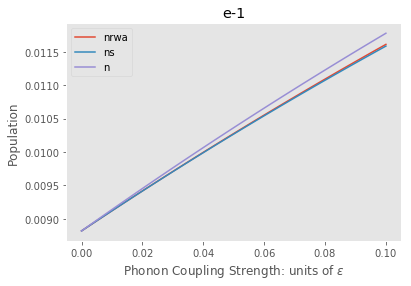

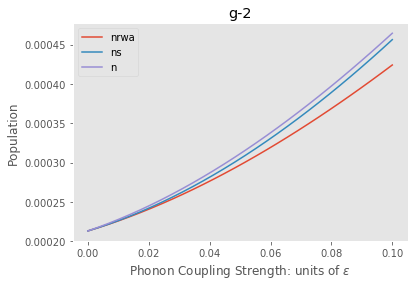

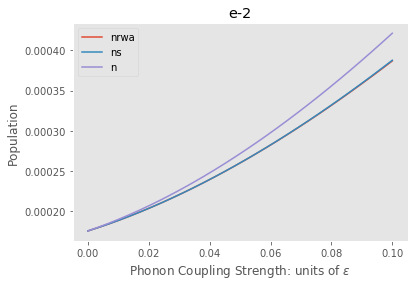

In [16]:
couplings = np.linspace(0,3,30)
steadystate_coupling_dependence(couplings, T_ph, eps, Gamma, w0, 
                                T_EM, Gamma_EM, overdamped=True)